# 1. Проблема
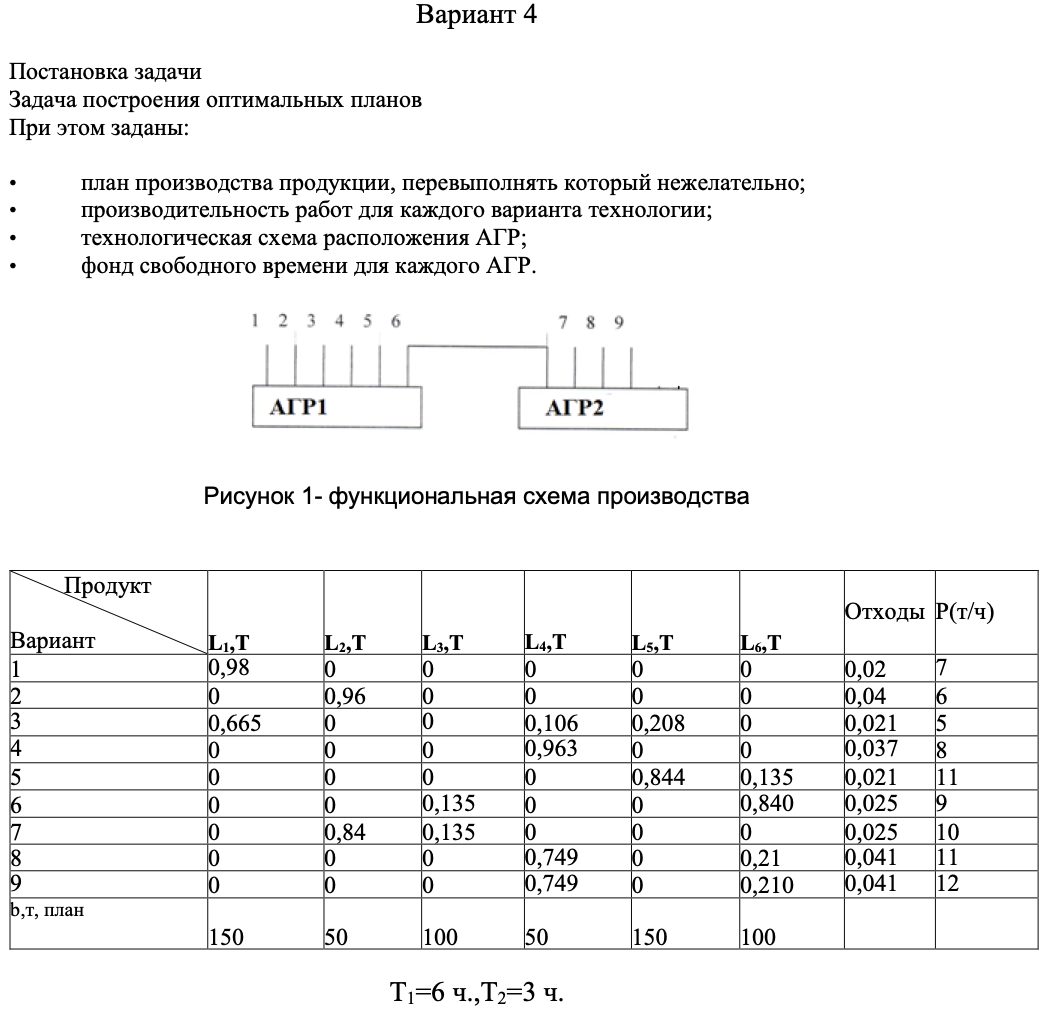

# 2. Содержательная постановка

Необходимо определить, как нужно распределить время работы АГР по различным вариантам работы, чтобы выполнить план, уложиться в ограничения по времени работы каждого АГР.

В качестве дополнительной задачи, необходимо разработать план работы АГР, чтобы:

1. минимизировать расход исходного материала

2. минимизировать отходы производства

# 3. Формальная постановка

## 1. Обозначения

Введем формальные обозначения для решения задачи в общем и в частном виде:

- $m = 9$ - число различных вариантов работы АГР;

- $n = 2$ - число различных АГР;

- $k = 6$ - число различных продуктов выхода АГР;

- $L = ||l_{ij}||,\ i \in \{1,2,\dots,k\},\ j \in \{1,2,\dots,m\}$ - Двумерное пространство долей выхода продуктов технологий производства;

- $P = (p_1,p_2,\dots,p_m)$ - Одномерное пространство мощностей каждого варианта;

- $B = (b_1,b_2,\dots,b_k)$ - Одномерное пространство плана производства продуктов;

- $W = (w_1,w_2,\dots,w_m)$ - Одномерное пространство отходов производства при каждом варианте;

- $T = (t_1,t_2,\dots,t_n)$ - Одномерное пространство фонда свободного времени АГР;

- $\mathcal{N} = (N_1,N_2,\dots,N_n)$ - Двумерное пространство вариантов работы каждого АГР. Здесь $N_i$ - Одномерное подпространства пространства $\mathcal{N}$ номеров вариантов работы для $i$ АГР соответственно;

- $X = ||x_{ij}||,\ i \in \{1,2,\dots,n\},\ j \in \{1,2,\dots,m\}$ - Двумерное пространство числа часов работы АГР на варианте;

- $E_\textrm{len} = (1,1,\dots,1)$ - Одномерное пространство единиц размера $\textrm{len}$.

## 2. Постановка задачи минимизации отходов

Запишем математическую модель задачи минимизации отходов, поскольку ресурс может быть ограничен:

Целевая функция:

- $\sum\limits_{i=1}^{m}w_ip_i(E_n, X)_i \rightarrow \min$
  
Условия:
  
- $\forall i,j:\ x_{ij} \geq 0$ - неотрицательность числа единиц времени;
  
- $\forall i:\ ((E_n, X), L)_i \leq b_i$ - неперевыполнение плана;
  
- $\forall i:\ \sum\limits_{j\in N_i}x_{ij} \leq t_i$ - ограниченность фонда свободного времени всех АГР.

- $\forall i, \forall j\not\in N_i:\ x_{ij} = 0$ - неиспользование неподдерживаемых технологий производства.
  

# 4. Алгоритм и ПО

Поставленная задача интерпретируется как задача линейного программирования с системой ограничений в виде неравенств.

Для ее решения будем симплекс-метод.

В качестве ПО будем использовать ЯП Python с подключенными модулями:

- numpy - для работы с линейной алгеброй;

- cvxpy - для работы с линейным программированием;

- pandas - для работы с табличными данными.

В качестве среды разработки Jupyter Lab.

# 5. Решение

## 1. Код программы

In [ ]:
def minimize_waste(L, p, b, w, N, t=None, accuracy=3, task='отходы', integer=True):
    '''
    Функция, решающая задачу о раскрое
    в трех вариантах:
    1. минимизация отходов
    2. минимизация затраченного времени АГР
    3. минимизация использования ресурсов.
    
    Вход программы:
    
    L - 2D-список
    долей выхода продуктов
    
    p - список
    мощности производства
    
    b - список
    плановых значений
    
    w - список
    производимых технологией ресурсов
    
    N - 2D-список
    поддерживаемых технологий
    
    t - список (опциональный параметр)
    ограничений по времени работы АГР,
    если не указать, то ограничений по времени не будет
    
    accuracy - целое число
    знаков после запятой
    на выводе программы
    
    task - строка
    с оптимизируемой функцией.
    Возможные значения:
    'отходы',
    'время',
    'ресурсы'.
    Если не указать, принимает
    значение 'отходы'
    
    integer - булево значение,
    целое ли число часов работы АГР

    Выход программы:
    
    Словарь формата
    {
    'Отходы'   : pandas.DataFrame,
    'Время'    : pandas.DataFrame,
    'Продукты' : pandas.DataFrame
    }
    '''
    
    import numpy as np
    import cvxpy
    import pandas as pd
    
    n = len(N)
    m = len(L)
    
    L = np.array(L)
    p = np.array(p)
    b = np.array(b)
    w = np.array(w)
    
    task = task.lower()
        
    if not t is None:
        t = np.array(t)
    
    x = cvxpy.Variable(shape=(n,m), integer = integer)

    constraints = [(x >= 0),
                    (cvxpy.multiply((([1]*n) @ x), p) @ L >= b)]
    for i in range(n):
        zero_constraint = (cvxpy.sum([x[i, j-1] for j in range(m) if j not in N[i]]) == 0)
        constraints.append(zero_constraint)
        if not t is None:
            time_constraint = (cvxpy.sum([x[i,j-1] for j in N[i]]) <= t[i])
            constraints.append(time_constraint)
                
    if task == 'отходы':
        total_value = cvxpy.sum(cvxpy.multiply(cvxpy.multiply(w, p),([1]*n) @ x))
    elif task == 'время':
        total_value = cvxpy.sum(x)
    elif task == 'ресурсы':
        total_value = cvxpy.sum(p @ (([1]*n) @ x))
    else:
        print('Введенное задание некорректно. Возможные значения: "Отходы", "Время", "Ресурсы". Работа программы завершена.')
        return None

    problem = cvxpy.Problem(cvxpy.Minimize(total_value), constraints=constraints)
    solution = problem.solve()
        
    if x.value is None:
        print('Поставленная задача не имеет решения. Работа программы прекращена.')
        return None
    
    def get_product_df():
        '''
        Функция, возвращающая
        таблицу произведенных продуктов
        '''
        
        products = np.around((([1]*n) @ x.value) * p @ L, accuracy)
        product_df = pd.DataFrame()
        product_df['Выход, т.'] = products
        product_df.index.names = ['Ресурс']
        product_df.index += 1
        product_df.loc['Итого'] = np.sum(products)
        
        return product_df
    
    def get_waste_df():
        '''
        Функция, возвращающая
        таблицу произведенных отходов
        '''
        
        waste = np.around((([1]*n) @ x.value) * p * w, accuracy)
        waste_df = pd.DataFrame()
        waste_df['Отходы, т.'] = waste
        waste_df.index.names = ['Технология']
        waste_df.index += 1
        waste_df.loc['Итого'] = np.sum(waste)
        
        return waste_df
        
    
    def get_tec_df():
        '''
        Функция, возвращающая
        таблицу распределения времени работы АГР
        по технологиям
        '''
        
        tec_matrix = np.abs(np.around(np.array(x.value), accuracy))
        tec_sum = np.sum(tec_matrix, axis = 1)
        tec_df = pd.DataFrame()
        for i in range(n):
            tec_df[f'Время работы АГР № {i+1}, ч.'] = tec_matrix[i]
        tec_df.index.names = ['Технология']
        tec_df.index += 1
        tec_df.loc['Итого'] = tec_sum
        
        return tec_df
    
    return {'Отходы': get_waste_df(), 
            'Время': get_tec_df(),
            'Продукты': get_product_df()}

## 2. Особенности работы программы

1. Программа возвращает словарь в формате словаря:
    ```
    Отходы   :  таблица отходов
    Время    :  таблица распределения времени работы АГР
    Продукты :  таблица произведенных продуктов
    ```
    Чтобы получить нужную таблицу, необходимо в квадратных скобка указать соответствующий таблице ключ словаря. Ввод строго с заглавной буквы.

2. Чтобы решить нужную задачу, нужно указать опциональный параметр ```task```. Возможные значения:

    ```
    task='Время'
    task='Отходы'
    task='Ресурсы'
    ```
    
    Допускается ввод параметра в любом регистре.

3. В случае, если нет ограничений по времени, их можно просто не указывать при запуске.

4. В случае, если есть возможность работать АГР не целое число часов, стоит указать значение параметра ```integer=False```. По умолчание его значение ```True```.

# 6. Анализ

Запишем данные в представлении ЯП:

In [ ]:
L = [[0.98,0,0,0,0,0],
     [0,0.96,0,0,0,0],
     [0.665,0,0,0.106,0.208,0],
     [0,0,0,0.963,0,0],
     [0,0,0,0,0.844,0.135],
     [0,0,0.135,0,0,0.840],
     [0,0.84,0.135,0,0,0],
     [0,0,0,0.749,0,0.21],
     [0,0,0,0.749,0,0.210]]

p = [7,6,5,8,11,9,10,11,12]

b = [150,50,100,50,150,100]

w = [0.02,0.04,0.021,0.037,0.021,0.025,0.025,0.041,0.041]

t = [6,3]

N = [[1,2,3,4,5,6],[7,8,9]]

Применим к ним нашу функцию:

In [ ]:
result = minimize_waste(L, p, b, w, N, t)

Поставленная задача не имеет решения. Работа программы прекращена.


Получаем вывод результата программой "Поставленная задача не имеет решения.". Это значит, что в поставленных условиях, задача линейного программирования не имеет вещественного решения.

Отсюда напрашивается корректировка задачи некоторыми уступками.

# 7. Корректировка задачи

## 1. Предположение

Предположим, что дополнительные закупки для производства продукции обходятся дороже, чем увеличение рабочего времени АГР. В таком случае уберем ограничение на время и будем минимизировать затраченные ресурсы на производство.

Кроме этого также решим задачу минимизации времени работы АГР, а также минимизации отходов производства для случая, если этот критерий производства очень важен.

## 2. Содержательная постановка откорректированной задачи

Необходимо определить, как нужно распределить время работы АГР по различным вариантам работы, чтобы выполнить план. При этом используя минимальное значение:

1. ресурсов

2. времени

3. произведенных отходов

## 3. Формальная постановка откорректированной задачи

Не будем вводить в уже введенные в пункте 3.1 обозначения, запишем лишь постановку задачи:

Целевая функция:

- $\sum\limits_{i=1}^{m}p_i(E_n, X)_i \rightarrow \min$ - в случае, если нам важно минимизировать затраченные ресурсы;

- $\sum\limits_{i=1}^m\sum\limits_{j=1}^nx_{ij} \rightarrow \min$ - в случае, если нам важно минимизировать суммарное время работы АГР;

- $\sum\limits_{i=1}^{m}w_ip_i(E_n, X)_i \rightarrow \min$ - в случае, если нам важно минимизировать отходы.

Условия:
  
- $\forall i,j:\ x_{ij} \geq 0$ - неотрицательность числа единиц времени;
  
- $\forall i:\ ((E_2, X), L)_i \leq b_i$ - неперевыполнение плана;

- $\forall i, \forall j\not\in N_i:\ x_{ij} = 0$ - неиспользование неподдерживаемых технологий производства.

## 4. Алгоритм и ПО откорректированной задачи

Здесь ничего не меняем.

## 5. Решение откорректированной задачи

Поскольку вариант отсутствия ограничений на время предусмотрен в решении, а также там предусмотрен выбор целевой функции, в анализе просто запустим программу, не указывая параметр ```t```.

## 6. Анализ решения откорректированной задачи

Запустим программу, не указывая параметр ```t```.

### 6.1 Минимизация затраченных ресурсов

In [ ]:
result = minimize_waste(L, p, b, w, N, task='Ресурсы', integer=True)

Посмотрим на таблицу выхода продукта:

In [ ]:
result['Продукты']

,"Выход, т."
Ресурс,
1,150.255
2,478.800
3,100.035
4,51.486
5,151.968
6,161.460
Итого,1094.004


В этом случае наблюдаем значительное превышение плана, примерно на $1.8\%$, так как у нас нет технологий, которые бы обеспечивали хорошее производство $L_3$ продукта. Необходимо купить АГР, которые будут поддерживать такую технологию.

Посмотрим на производимое по данной схеме число отходов:

In [63]:
result['Отходы']

,"Отходы, т."
Технология,
1,0.420
2,0.000
3,4.095
4,1.184
5,2.772
6,4.275
7,14.250
8,0.000
9,0.000


По данной схеме получаем число отходов, равное примерно $27$ тонн. Это составляет примерно $2.4\%$ от использованного ресурса.

Число использованного ресурса равно сумме произведенных продуктов и отходов. Это число равно $1121$ тоннам.

Посмотрим на распределение времени работы АГР:

In [64]:
result['Время']

,"Время работы АГР № 1, ч.","Время работы АГР № 2, ч."
Технология,,
1,3.0,0.0
2,0.0,0.0
3,39.0,0.0
4,4.0,0.0
5,12.0,0.0
6,19.0,0.0
7,0.0,57.0
8,0.0,0.0
9,0.0,0.0


В сумме получаем $77$ и $57$ часов соответственно, что превышает данные в исходной задаче ограничения почти в $13$ и $19$ раз соответственно.

### 6.2 Минимизация затраченного времени

Запустим программу:

In [65]:
result = minimize_waste(L, p, b, w, N, task='Время', integer=True)

Сразу же посмотрим на распределение времени работы АГР:

In [66]:
result['Время']

,"Время работы АГР № 1, ч.","Время работы АГР № 2, ч."
Технология,,
1,21.0,0.0
2,0.0,0.0
3,2.0,0.0
4,0.0,0.0
5,16.0,0.0
6,9.0,0.0
7,0.0,66.0
8,0.0,6.0
9,0.0,0.0


Получаем в сумме $48$ и $72$ часов работы соответственно для каждого АГР. Это распределение уравнивает превышение данных в исходной задаче ограничений. Получаем превышение в $8$ и $24$ раз соответственно. При этом суммарное время изменилось не сильно. Было $134$ часа на оба АГР, стало $120$ часов на оба АГР. Так как, скорее всего АГР могут работать одновременно, данное решение нас устроит больше в этом критерии.


Посмотрим распределение произведенных продуктов и отходов:

In [67]:
result['Продукты']

,"Выход, т."
Ресурс,
1,150.710
2,554.400
3,100.035
4,50.494
5,150.624
6,105.660
Итого,1111.923


Также видим значительное перевыполнение плана, еще больше, чем при минимизации затраченных ресурсов.

In [68]:
result['Отходы']

,"Отходы, т."
Технология,
1,2.940
2,0.000
3,0.210
4,0.000
5,3.696
6,2.025
7,16.500
8,2.706
9,0.000


Видим, что число производимых отходов тоже увеличивается. По сравнению с предыдущим решением, на 1 тонну.

Итого число затрачиваемых ресурсов по сравнению с предыдущим решением увеличивается на $19$ тонн.

### 6.3 Минимизация отходов

Приведем также анализ решения задачи минимизации отходов с учетом отсутствия ограничения по времени.

In [69]:
result = minimize_waste(L, p, b, w, N, task='Отходы', integer=True)

Т.к. главным критерием этого решения является число отходов, первым делом посмотрим на него.

In [70]:
result['Отходы']

,"Отходы, т."
Технология,
1,0.420
2,0.000
3,4.095
4,1.184
5,2.772
6,4.275
7,14.250
8,0.000
9,0.000


Из таблицы видим, что снизить отходы по сравнению с первым решением (минимизация затраченных ресурсов) не получится, а вот если сравнивать с решением, где мы минимизируем затраченное время, то отходов у нас на $2$ тонны меньше.

Проверим остальные данные.

In [71]:
result['Продукты']

,"Выход, т."
Ресурс,
1,150.255
2,478.800
3,100.035
4,51.486
5,151.968
6,161.460
Итого,1094.004


Наблюдаем такое же перевыполнения плана как при минимизации затраченных ресурсов.

In [72]:
result['Время']

,"Время работы АГР № 1, ч.","Время работы АГР № 2, ч."
Технология,,
1,3.0,0.0
2,0.0,0.0
3,39.0,0.0
4,4.0,0.0
5,12.0,0.0
6,19.0,0.0
7,0.0,57.0
8,0.0,0.0
9,0.0,0.0


Видим тот же самый результат, что и при минимизации затраченных ресурсов.

## 8. Вывод

Снятие ограничений на время работы АГР или план выхода продукта пусть и позволяют решить поставленные задачи, но затраченное время и суммарный план выхода продукта существенно превышают предоставленные в исходной задаче ограничения. Если подразумевать выполнение плана хотя бы за 2 недели без выходных, задача имеет решение.

Исходя из полученных ответов в предыдущем пункте, не имеет смысла использовать схему квазилексикографической оптимизации, которая может быть предложена для рассмотрения.

Дальнейший анализ того, какое из полученных трех решений, следует использовать требует дополнительных данных метрик: стоимость утилизации ресурсов, себестоимость ресурсов, стоимость часа работы АГР.

На основе этих результатов можно предложить:

- частично снизить план производства продуктов

- закупить дополнительное или более производительное оборудование

- закупить оборудование, которое бы обеспечивало хорошее производство $L_3$ продукта